# Knowledge-Aware Recommender V2 (PyTorch Geometric Version)

**Architecture:**
1.  **Deep & Wide:** Embedding dimensions (256/512).
2.  **Rating-Aware Attention:** Custom PyG MessagePassing layer that attends to neighbors + edge ratings.
3.  **Complementary Fusion:** Graph + Text.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from recomender_metrics import evaluate_recommendations, print_evaluation_results
from torch_geometric.data import HeteroData
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Configuration
EMBED_DIM = 128
HIDDEN_DIM = 256
ATTENTION_HEADS = 4
DROPOUT = 0.3
LR = 0.001
EPOCHS = 15
BATCH_SIZE = 512 # Can increase batch size now that model is lighter
TEXT_EMBED_PATH = 'movie_text_embeddings.pt'

Using device: cuda


## 1. Data Loading: Building HeteroData (PyG)
PyG stores graphs in a `HeteroData` object.
Edge indices are tensors of shape `[2, num_edges]`.

In [ ]:
def load_data_and_build_graph():
    print("Loading datasets...")

    movies_df = pd.read_csv('movies_graph_ready.csv')
    train_df = pd.read_csv('ml-100k/u1.base', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
    test_df = pd.read_csv('ml-100k/u1.test', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])

    nodes_dir = 'nodes'
    genres_df = pd.read_csv(f'{nodes_dir}/genres.csv')
    keywords_df = pd.read_csv(f'{nodes_dir}/keywords.csv')
    directors_df = pd.read_csv(f'{nodes_dir}/directors.csv')
    writers_df = pd.read_csv(f'{nodes_dir}/writers.csv')

    # --- ID MAPPING ---
    all_users = pd.concat([train_df['user_id'], test_df['user_id']]).unique()
    all_movies = movies_df['ml_movie_id'].unique()

    user_map = {uid: i for i, uid in enumerate(all_users)}
    movie_map = {mid: i for i, mid in enumerate(all_movies)}

    # Reverse mappings
    id_to_user = {v: k for k, v in user_map.items()}
    id_to_movie = {v: k for k, v in movie_map.items()}

    # Aux nodes maps
    genre_map = {gid: i for i, gid in enumerate(genres_df['id'])}
    keyword_map = {kid: i for i, kid in enumerate(keywords_df['id'])}
    director_map = {did: i for i, did in enumerate(directors_df['id'])}
    writer_map = {wid: i for i, wid in enumerate(writers_df['id'])}

    # --- GRAPH CONSTRUCTION (PyG HeteroData) ---
    data = HeteroData()

    # Set Number of Nodes (Important for PyG)
    data['user'].num_nodes = len(user_map)
    data['movie'].num_nodes = len(movie_map)
    data['genre'].num_nodes = len(genre_map)
    data['keyword'].num_nodes = len(keyword_map)
    data['director'].num_nodes = len(director_map)
    data['writer'].num_nodes = len(writer_map)

    # User-Movie Edges (ALL RATINGS)
    u_list, m_list, r_list = [], [], []

    valid_u = set(user_map.keys())
    valid_m = set(movie_map.keys())

    print("Building User-Movie edges with Ratings...")
    for u, m, r in zip(train_df['user_id'], train_df['movie_id'], train_df['rating']):
        if u in valid_u and m in valid_m:
            u_list.append(user_map[u])
            m_list.append(movie_map[m])
            r_list.append(r - 1) # 0-4 index

    # PyG expects edge_index as [2, Num_Edges]
    rates_index = torch.tensor([u_list, m_list], dtype=torch.long)
    rated_by_index = torch.tensor([m_list, u_list], dtype=torch.long)
    ratings = torch.tensor(r_list, dtype=torch.long)

    data['user', 'rates', 'movie'].edge_index = rates_index
    data['user', 'rates', 'movie'].rating = ratings

    data['movie', 'rated_by', 'user'].edge_index = rated_by_index
    data['movie', 'rated_by', 'user'].rating = ratings # Symmetric rating info

    # Metadata Edges
    def build_attr_edges(df, col_name, map_dict, target_ntype, edge_name):
        src, dst = [], []
        for _, row in df.iterrows():
            if row['ml_movie_id'] not in movie_map: continue
            mid = movie_map[row['ml_movie_id']]
            try:
                ids = json.loads(row[col_name])
                if isinstance(ids, list):
                    for x in ids:
                        if x in map_dict:
                            src.append(mid); dst.append(map_dict[x])
            except: continue

        if len(src) > 0:
            edge_index = torch.tensor([src, dst], dtype=torch.long)
            rev_edge_index = torch.tensor([dst, src], dtype=torch.long)

            data['movie', f'has_{edge_name}', target_ntype].edge_index = edge_index
            data[target_ntype, f'{edge_name}_of', 'movie'].edge_index = rev_edge_index

    build_attr_edges(movies_df, 'genres', genre_map, 'genre', 'genre')
    build_attr_edges(movies_df, 'keywords', keyword_map, 'keyword', 'keyword')
    build_attr_edges(movies_df, 'directors', director_map, 'director', 'director')
    build_attr_edges(movies_df, 'writers', writer_map, 'writer', 'writer')

    # --- EVALUATION METADATA ---
    movie_genres_dict = {}
    id_to_genre_name = dict(zip(genres_df['id'], genres_df['name']))

    for _, row in movies_df.iterrows():
        mid = str(row['ml_movie_id'])
        try:
            g_ids = json.loads(row['genres'])
            names = {id_to_genre_name.get(gid, 'unknown') for gid in g_ids}
            movie_genres_dict[mid] = names
        except:
            movie_genres_dict[mid] = set()

    mappings = {
        'user_map': user_map, 'movie_map': movie_map,
        'id_to_user': id_to_user, 'id_to_movie': id_to_movie,
        'movie_genres': movie_genres_dict
    }

    return data, mappings, train_df, test_df

## 2. Custom PyG Graph Layer
We implement `RatingAwareGAT` by inheriting from `MessagePassing`.
This requires handling the heterogeneity manually or via wrapper. Here we use a ModuleDict to handle different relation types explicitly.

In [ ]:
class SingleRelationGAT(MessagePassing):
    """
    Performs the attention mechanism for ONE specific edge type (e.g., User->Movie).
    Supports optional edge rating features.
    """
    def __init__(self, in_feat, out_feat, num_heads, feat_drop, has_rating=False):
        super().__init__(node_dim=0, aggr='add') # Target node aggregation is sum
        self.out_feat = out_feat
        self.num_heads = num_heads
        self.has_rating = has_rating

        # Transformation W
        self.W = nn.Linear(in_feat, out_feat * num_heads, bias=False)

        # Attention Vectors
        self.attn_l = nn.Parameter(torch.randn(1, num_heads, out_feat))
        self.attn_r = nn.Parameter(torch.randn(1, num_heads, out_feat))

        if has_rating:
            # 5 ratings -> mapped to attention space
            self.rating_embedding = nn.Embedding(5, out_feat * num_heads)
            self.attn_rating = nn.Parameter(torch.randn(1, num_heads, out_feat))

        self.feat_drop = nn.Dropout(feat_drop)
        self.leaky_relu = nn.LeakyReLU(0.2)

        nn.init.xavier_uniform_(self.W.weight)
        nn.init.xavier_uniform_(self.attn_l)
        nn.init.xavier_uniform_(self.attn_r)

    def forward(self, x_src, x_dst, edge_index, rel_emb, edge_rating=None):
        # x_src: [N_src, In]
        # rel_emb: [In] -> Broadcast to [N_src, In]

        # Transform Source (Add Relation Embedding first)
        # We pass (x_src + rel) to the message function to project it there
        # Or project here for efficiency.

        # Project Source
        h_src = self.W(x_src + rel_emb).view(-1, self.num_heads, self.out_feat)
        # Project Dest
        h_dst = self.W(x_dst).view(-1, self.num_heads, self.out_feat)

        # Pre-calculate Attention Terms (Optimization)
        # alpha_l = (W(h+r) * a_l).sum
        alpha_l = (h_src * self.attn_l).sum(dim=-1) # [N_src, Heads]
        alpha_r = (h_dst * self.attn_r).sum(dim=-1) # [N_dst, Heads]

        # Propagate
        # Flow: Source -> Target
        out = self.propagate(edge_index, x=(h_src, h_dst), alpha=(alpha_l, alpha_r), edge_rating=edge_rating)

        # Final transformation (Mean over heads + Activation)
        out = out.mean(dim=1) # [N_dst, Out]
        return self.leaky_relu(out)

    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i, edge_rating):
        # x_j: Source Node Features (Projected) [E, Heads, Out]
        # alpha_j: Source Attention Term [E, Heads]
        # alpha_i: Target Attention Term [E, Heads]
        # index: The indices of destination nodes (for softmax)

        # Base Attention Score
        score = alpha_j + alpha_i

        # Add Rating Info if available
        if self.has_rating and edge_rating is not None:
            # Embed Rating: [E] -> [E, Heads*Out] -> [E, Heads, Out]
            r_emb = self.rating_embedding(edge_rating).view(-1, self.num_heads, self.out_feat)
            # Attention contribution: (r_emb * attn_vec).sum
            r_score = (r_emb * self.attn_rating).sum(dim=-1) # [E, Heads]
            score = score + r_score

        score = F.leaky_relu(score, 0.2)

        # Softmax over neighbors
        alpha = softmax(score, index, ptr, size_i) # [E, Heads]
        alpha = F.dropout(alpha, p=0.2, training=self.training)

        # Weighted Sum
        return x_j * alpha.unsqueeze(-1)

class HeteroRatingGAT(nn.Module):
    def __init__(self, data_metadata, in_feat, out_feat, num_heads, feat_drop=0.4):
        super().__init__()
        self.node_types, self.edge_types = data_metadata

        # Learnable Relation Embeddings (Node-Level, unique per relation type)
        self.rel_embeddings = nn.ParameterDict()
        for src, rel, dst in self.edge_types:
            self.rel_embeddings[f'{src}__{rel}__{dst}'] = nn.Parameter(torch.randn(in_feat))

        # Create a GAT Layer for each edge type
        self.convs = nn.ModuleDict()
        for src, rel, dst in self.edge_types:
            key = f'{src}__{rel}__{dst}'
            # Only 'rates' and 'rated_by' have ratings
            has_rating = (rel == 'rates' or rel == 'rated_by')
            self.convs[key] = SingleRelationGAT(in_feat, out_feat, num_heads, feat_drop, has_rating)

    def forward(self, x_dict, edge_index_dict, edge_attr_dict=None):
        out_dict = defaultdict(list)

        # Iterate over all edge types
        for src, rel, dst in self.edge_types:
            key = f'{src}__{rel}__{dst}'
            edge_index = edge_index_dict[(src, rel, dst)]

            # Skip if edge type empty
            if edge_index.numel() == 0: continue

            # Get inputs
            x_src = x_dict[src]
            x_dst = x_dict[dst]
            rel_emb = self.rel_embeddings[key]

            # Get ratings if available
            ratings = None
            if edge_attr_dict and (src, rel, dst) in edge_attr_dict:
                ratings = edge_attr_dict[(src, rel, dst)]

            # Compute Message Passing for this edge type
            out = self.convs[key](x_src, x_dst, edge_index, rel_emb, ratings)
            out_dict[dst].append(out)

        # Aggregate results for each node type (Sum Aggregation)
        final_out = {}
        for ntype, outs in out_dict.items():
            if len(outs) > 0:
                final_out[ntype] = sum(outs)
            else:
                # Handle isolated nodes (just return zeros or original)
                # Since we changed dimensions, we return zeros
                final_out[ntype] = torch.zeros((x_dict[ntype].size(0), self.convs.values().__iter__().__next__().out_feat), device=x_dict[ntype].device)

        return final_out

## 3. Text Module & Fusion (PyTorch)
These remain largely standard PyTorch modules.

In [ ]:
class DeepReviewAggregator(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.proj = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.query = nn.Linear(hidden_dim, 1)

    def forward(self, review_embs, mask=None):
        # review_embs: [B, M, Emb]
        h = self.proj(review_embs) # [B, M, Hidden]
        scores = self.query(h) # [B, M, 1]

        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(-1) == 0, -1e9)
        weights = F.softmax(scores, dim=1)

        return (weights * h).sum(dim=1) # [B, Hidden]

class GatedCrossAttention(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)
        self.gate = nn.Sequential(nn.Linear(dim * 2, dim), nn.Sigmoid())
        self.norm = nn.LayerNorm(dim)

    def forward(self, x_graph, x_text):
        q = x_graph.unsqueeze(1)
        k = v = x_text.unsqueeze(1)
        attn_out, _ = self.mha(q, k, v)
        attn_out = attn_out.squeeze(1)

        concat = torch.cat([x_graph, attn_out], dim=-1)
        alpha = self.gate(concat)
        return self.norm(alpha * x_graph + (1 - alpha) * attn_out)

## 4. Full Model Assembly

In [ ]:
class RecommenderPyG(nn.Module):
    def __init__(self, metadata, text_input_dim, hidden_dim, num_heads):
        super().__init__()
        node_types, _ = metadata

        # Initial Node Embeddings
        # PyG doesn't store embeddings in the graph object automatically like DGL
        # We manage them here.
        self.node_embeds = nn.ModuleDict()
        # We need num_nodes. In PyG metadata doesn't strictly provide counts unless passed separately.
        # We will initialize these dynamically or pass a dict.
        # For now, we will assume `num_nodes_dict` is passed in `__init__` or handled externally.
        # Updated init signature to accept `num_nodes_dict`
        pass

    def init_embeddings(self, num_nodes_dict, hidden_dim):
        self.node_embeds = nn.ModuleDict()
        for ntype, count in num_nodes_dict.items():
            self.node_embeds[ntype] = nn.Embedding(count, hidden_dim)

    def setup_layers(self, metadata, text_input_dim, hidden_dim, num_heads):
        self.text_proj = nn.Sequential(nn.Linear(text_input_dim, hidden_dim), nn.ReLU())
        self.gnn = HeteroRatingGAT(metadata, hidden_dim, hidden_dim, num_heads)
        self.review_agg = DeepReviewAggregator(hidden_dim, hidden_dim)
        self.fusion = GatedCrossAttention(hidden_dim, num_heads)
        self.predict_layer = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x_dict, edge_index_dict, edge_attr_dict, users, items, ov, rev, mask):
        # Get initial features from embeddings
        # If x_dict contains indices, embed them.
        h_dict = {ntype: self.node_embeds[ntype](x_dict[ntype]) for ntype in x_dict}

        # Graph Pass
        h_dict = self.gnn(h_dict, edge_index_dict, edge_attr_dict)
        u_graph = h_dict['user'][users]
        i_graph = h_dict['movie'][items]

        # Text Pass
        feat_ov = self.text_proj(ov)
        feat_rev_raw = self.text_proj(rev)
        agg_rev = self.review_agg(feat_rev_raw, mask)
        i_text = (feat_ov + agg_rev) / 2

        # Fusion
        i_fused = self.fusion(i_graph, i_text)

        # Predict
        x = torch.cat([u_graph, i_fused], dim=-1)
        return self.predict_layer(x)

    def get_all_embeddings(self, x_dict, edge_index_dict, edge_attr_dict, ov, rev, mask):
        with torch.no_grad():
            h_dict = {ntype: self.node_embeds[ntype](x_dict[ntype]) for ntype in x_dict}
            h_dict = self.gnn(h_dict, edge_index_dict, edge_attr_dict)

            feat_ov = self.text_proj(ov)
            feat_rev_raw = self.text_proj(rev)
            agg_rev = self.review_agg(feat_rev_raw, mask)
            i_text_all = (feat_ov + agg_rev) / 2

            i_fused_all = self.fusion(h_dict['movie'], i_text_all)
            return h_dict['user'], i_fused_all

# Wrapper to instantiate properly
def create_model(data, text_dim, hidden_dim, num_heads):
    model = RecommenderPyG(data.metadata(), text_dim, hidden_dim, num_heads)
    # Convert HeteroData counts to dict
    counts = {ntype: data[ntype].num_nodes for ntype in data.node_types}
    model.init_embeddings(counts, hidden_dim)
    model.setup_layers(data.metadata(), text_dim, hidden_dim, num_heads)
    return model

## 5. Evaluation & Training Utils

In [ ]:
def align_text_embeddings(movie_map, pt_file_path):
    data = torch.load(pt_file_path, weights_only=False)
    raw_ids, ov_embs, rev_embs, masks = data['movie_ids'], data['overview_embs'], data['review_embs'], data['review_mask']

    num_movies = len(movie_map)
    dim = ov_embs.shape[1]
    max_rev = rev_embs.shape[1]

    ao = torch.zeros((num_movies, dim))
    ar = torch.zeros((num_movies, max_rev, dim))
    am = torch.zeros((num_movies, max_rev))

    for i, mid in enumerate(raw_ids):
        if mid in movie_map:
            idx = movie_map[mid]
            ao[idx] = ov_embs[i]
            ar[idx] = rev_embs[i]
            am[idx] = masks[i]
    return ao, ar, am

class BPRDataset(Dataset):
    def __init__(self, train_df, user_map, movie_map):
        self.data = []
        valid_u = set(user_map.keys())
        valid_m = set(movie_map.keys())
        self.user_hist = defaultdict(set)
        self.all_items = list(movie_map.values())

        pos_df = train_df[train_df['rating'] >= 4]

        for u, m in zip(pos_df['user_id'], pos_df['movie_id']):
            if u in valid_u and m in valid_m:
                uid, mid = user_map[u], movie_map[m]
                self.data.append((uid, mid))
                self.user_hist[uid].add(mid)

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        u, pos = self.data[idx]
        while True:
            neg = np.random.choice(self.all_items)
            if neg not in self.user_hist[u]: break
        return torch.tensor(u), torch.tensor(pos), torch.tensor(neg)

def prepare_eval_data(train_df, test_df, movies_df, mappings):
    print("Constructing Evaluation Dictionaries...")
    ground_truth = (test_df[test_df['rating'] >= 4]
                    .groupby('user_id')
                    .apply(lambda x: dict(zip(x['movie_id'].astype(str), x['rating'])))
                    .to_dict())
    ground_truth = {str(k): v for k, v in ground_truth.items()}

    item_popularity = train_df.groupby('movie_id')['rating'].count().to_dict()
    item_popularity = {str(k): v for k, v in item_popularity.items()}

    item_features = mappings['movie_genres']
    all_items = set(str(m) for m in mappings['movie_map'].keys())
    return ground_truth, item_popularity, item_features, all_items

def generate_recommendations(model, data, mappings, ov, rev, mask, train_df, k=50):
    print("Generating Recommendations...")
    model.eval()

    # Prepare Graph Inputs
    x_dict = {n: torch.arange(data[n].num_nodes).to(device) for n in data.node_types}
    edge_index_dict = {e: data[e].edge_index for e in data.edge_types}
    edge_attr_dict = {}
    for e in data.edge_types:
        if 'rating' in data[e]:
            edge_attr_dict[e] = data[e].rating

    u_all, i_all = model.get_all_embeddings(x_dict, edge_index_dict, edge_attr_dict, ov, rev, mask)

    user_history = train_df.groupby('user_id')['movie_id'].apply(set).to_dict()
    test_users = list(mappings['id_to_user'].keys())
    id_to_movie = mappings['id_to_movie']

    recommendations = {}
    BATCH = 100
    num_items = i_all.shape[0]

    with torch.no_grad():
        for i in tqdm(range(0, len(test_users), BATCH)):
            batch_idx = test_users[i : i + BATCH]
            u_emb = u_all[batch_idx]

            x = torch.cat([
                u_emb.unsqueeze(1).expand(-1, num_items, -1),
                i_all.unsqueeze(0).expand(len(batch_idx), -1, -1)
            ], dim=-1)

            scores = model.predict_layer(x).squeeze(-1)
            _, top_indices = torch.sort(scores, descending=True)
            top_indices = top_indices.cpu().numpy()

            for j, u_pyg_id in enumerate(batch_idx):
                real_u_id = str(mappings['id_to_user'][u_pyg_id])
                seen = user_history.get(int(real_u_id), set())
                recs = []
                for item_idx in top_indices[j]:
                    real_item = id_to_movie[item_idx]
                    if real_item not in seen:
                        recs.append(str(real_item))
                        if len(recs) == k: break
                recommendations[real_u_id] = recs
    return recommendations

## 6. Execution

Loading datasets...
Building User-Movie edges with Ratings...
Model Params: 5965826


Epoch 1: 100%|██████████| 86/86 [00:22<00:00,  3.82it/s]


Loss: 0.3642


Epoch 2: 100%|██████████| 86/86 [00:21<00:00,  3.91it/s]


Loss: 0.3102


Epoch 3: 100%|██████████| 86/86 [00:24<00:00,  3.57it/s]


Loss: 0.3088


Epoch 4: 100%|██████████| 86/86 [00:22<00:00,  3.80it/s]


Loss: 0.3052


Epoch 5: 100%|██████████| 86/86 [00:22<00:00,  3.79it/s]


Loss: 0.2988


Epoch 6: 100%|██████████| 86/86 [00:22<00:00,  3.82it/s]


Loss: 0.2971


Epoch 7: 100%|██████████| 86/86 [00:23<00:00,  3.74it/s]


Loss: 0.2947


Epoch 8: 100%|██████████| 86/86 [00:22<00:00,  3.79it/s]


Loss: 0.2922


Epoch 9: 100%|██████████| 86/86 [00:22<00:00,  3.84it/s]


Loss: 0.2807


Epoch 10: 100%|██████████| 86/86 [00:22<00:00,  3.86it/s]


Loss: 0.2718


Epoch 11: 100%|██████████| 86/86 [00:22<00:00,  3.78it/s]


Loss: 0.2634


Epoch 12: 100%|██████████| 86/86 [00:22<00:00,  3.82it/s]


Loss: 0.2558


Epoch 13: 100%|██████████| 86/86 [00:22<00:00,  3.80it/s]


Loss: 0.2528


Epoch 14: 100%|██████████| 86/86 [00:22<00:00,  3.82it/s]


Loss: 0.2568


Epoch 15: 100%|██████████| 86/86 [00:22<00:00,  3.83it/s]

Loss: 0.2488


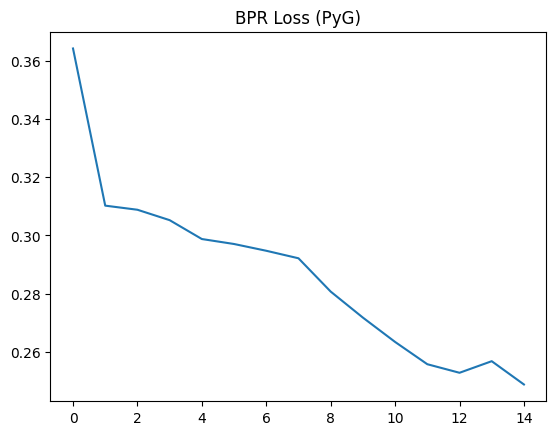

In [ ]:
# Load Data (PyG)
data, mappings, train_df, test_df = load_data_and_build_graph()
data = data.to(device)

# Text
ov, rev, mask = align_text_embeddings(mappings['movie_map'], TEXT_EMBED_PATH)
ov, rev, mask = ov.to(device), rev.to(device), mask.to(device)

# Dataset
dataset = BPRDataset(train_df, mappings['user_map'], mappings['movie_map'])
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model
model = create_model(data, 384, HIDDEN_DIM, ATTENTION_HEADS).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR)

print(f"Model Params: {sum(p.numel() for p in model.parameters())}")

# Train
loss_hist = []

# Pre-fetch graph inputs to avoid dictionary overhead in loop
x_dict = {n: torch.arange(data[n].num_nodes).to(device) for n in data.node_types}
edge_index_dict = {e: data[e].edge_index for e in data.edge_types}
edge_attr_dict = {}
for e in data.edge_types:
    if 'rating' in data[e]:
        edge_attr_dict[e] = data[e].rating

for epoch in range(EPOCHS):
    model.train()
    ep_loss = 0
    for u, pos, neg in tqdm(loader, desc=f"Epoch {epoch+1}"):
        u, pos, neg = u.to(device), pos.to(device), neg.to(device)

        p_ov, p_rev, p_mask = ov[pos], rev[pos], mask[pos]
        n_ov, n_rev, n_mask = ov[neg], rev[neg], mask[neg]

        # Forward Pass Positive
        pos_sc = model(x_dict, edge_index_dict, edge_attr_dict, u, pos, p_ov, p_rev, p_mask)
        # Forward Pass Negative
        neg_sc = model(x_dict, edge_index_dict, edge_attr_dict, u, neg, n_ov, n_rev, n_mask)

        loss = -torch.mean(torch.log(torch.sigmoid(pos_sc - neg_sc)))

        opt.zero_grad()
        loss.backward()
        opt.step()
        ep_loss += loss.item()

    avg = ep_loss / len(loader)
    loss_hist.append(avg)
    print(f"Loss: {avg:.4f}")

plt.plot(loss_hist)
plt.title("BPR Loss (PyG)")
plt.show()

In [ ]:
recs = generate_recommendations(model, data, mappings, ov, rev, mask, train_df)
gt, pop, feats, all_items = prepare_eval_data(train_df, test_df, pd.read_csv('movies_graph_ready.csv'), mappings)

print(f"Generated Recs for {len(recs)} users.")
results = evaluate_recommendations(recs, gt, [10, 20, 50], pop, feats, all_items)
print_evaluation_results(results)

Generating Recommendations...


100%|██████████| 10/10 [00:00<00:00, 50.32it/s]
/tmp/ipython-input-4134193410.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: dict(zip(x['movie_id'].astype(str), x['rating'])))


Constructing Evaluation Dictionaries...
Generated Recs for 943 users.

RECOMMENDATION EVALUATION RESULTS

CATALOG COVERAGE:
  @10: 0.0849
  @20: 0.1282
  @50: 0.2350

F1:
  @10: 0.1823
  @20: 0.2020
  @50: 0.2052

INTRA LIST SIMILARITY:
  @10: 1.0000
  @20: 1.0000
  @50: 1.0000

MAP:
  @10: 0.4793
  @20: 0.4241
  @50: 0.3450

MRR:
  @10: 0.5456
  @20: 0.5509
  @50: 0.5528

NDCG:
  @10: 0.3189
  @20: 0.3153
  @50: 0.3451

NOVELTY:
  @10: 8.1065
  @20: 8.3260
  @50: 8.6478

PRECISION:
  @10: 0.2682
  @20: 0.2259
  @50: 0.1673

RECALL:
  @10: 0.1476
  @20: 0.2383
  @50: 0.4086

